In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

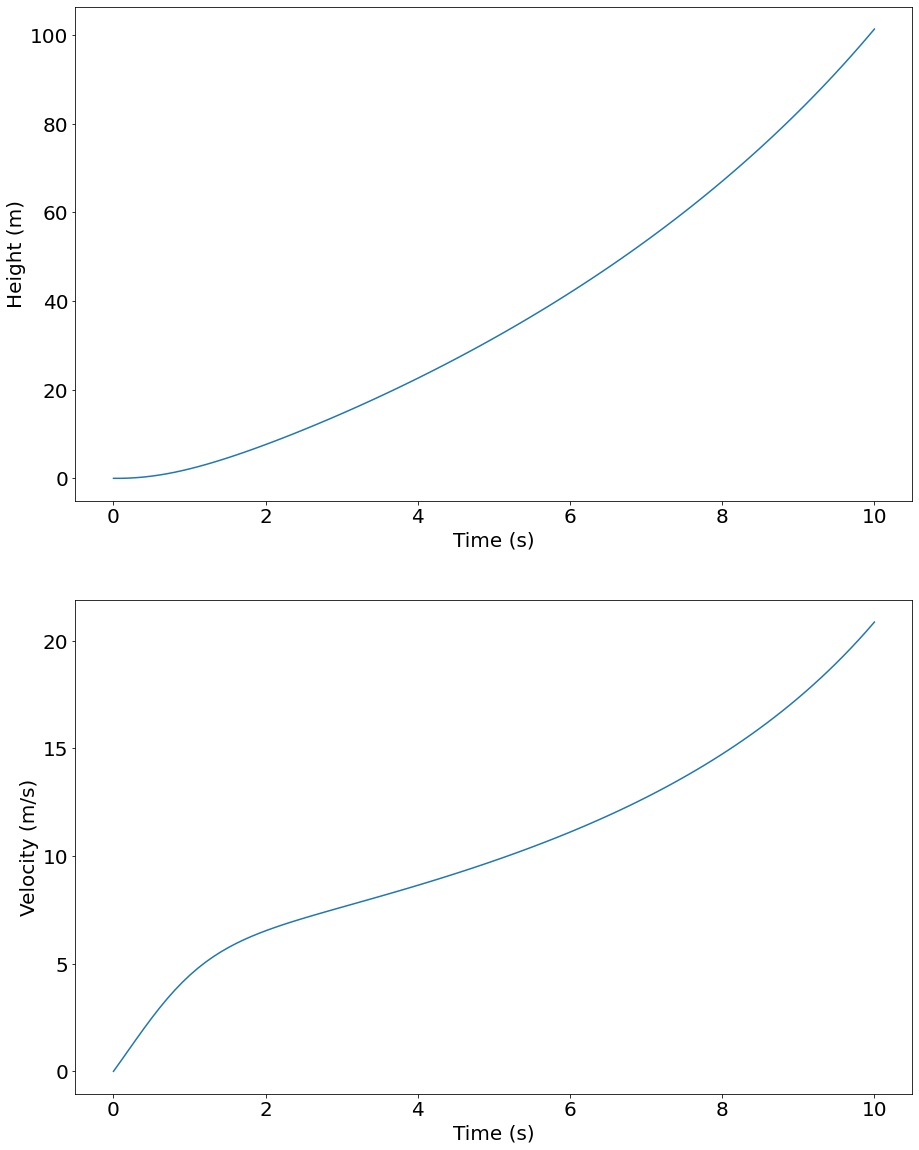

In [2]:
# Define the scenario.

dt = 0.1  # Time step
n = 100   # Duration (in time steps)
t = np.linspace(0, dt * n, n)

# Constants/functions for (exceedingly fictional) drag model
surface_atm_density = 3e-2  # Atmospheric density at the surface (Pa)
calc_atm_density = lambda height: surface_atm_density * (1 - 3e-3 * height) ** 5
def calc_drag(height, velocity):
    atm_density = calc_atm_density(height)
    return 0.5 * atm_density * velocity ** 2

commanded_acceleration = 5 + 0.1 * np.arange(n)
true_acceleration = commanded_acceleration.copy()
true_velocity = np.zeros(n)
true_height = np.zeros(n)

# Account for drag
for k in range(1, n):
    drag = calc_drag(true_height[k-1], true_velocity[k-1])
    true_velocity[k] = true_velocity[k-1] + true_acceleration[k-1] * dt - drag
    true_height[k] = true_height[k-1] + true_velocity[k-1] * dt

plt.figure(figsize=(15, 20))
plt.rc("font", size=20)
plt.subplot(2, 1, 1)
plt.plot(t, true_height, label="Height")
plt.ylabel("Height (m)")
plt.xlabel("Time (s)")
plt.subplot(2, 1, 2)
plt.plot(t, true_velocity, label="Velocity")
plt.ylabel("Velocity (m/s)")
plt.xlabel("Time (s)")
plt.show()

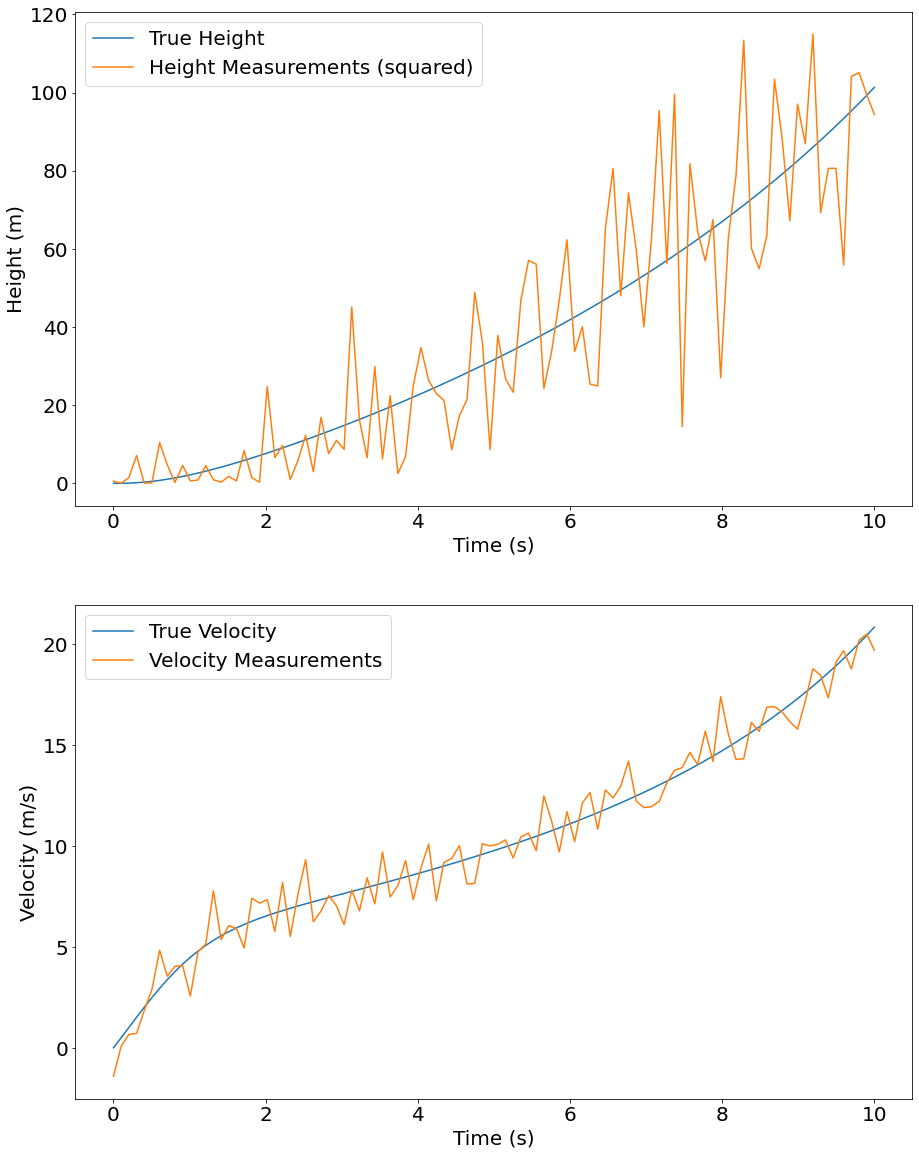

Height Error:
  Sensor only:    15.275 m (RMS)
Velocity Error:
  Sensor only:    0.949 m/s (RMS)


In [3]:
# Sensors only.

height_variance = np.sqrt(5)
velocity_variance = 1

height_measurements = np.sqrt(true_height) + np.random.normal(0, np.sqrt(height_variance), n)
velocity_measurements = true_velocity + np.random.normal(0, np.sqrt(velocity_variance), n)

height_measurement_error = true_height - height_measurements**2
velocity_measurement_error = true_velocity - velocity_measurements
height_measurement_rms_error = np.sqrt(np.mean(height_measurement_error**2))
velocity_measurement_rms_error = np.sqrt(np.mean(velocity_measurement_error**2))

plt.figure(figsize=(15, 20))
plt.rc("font", size=20)
plt.subplot(2, 1, 1)
plt.plot(t, true_height, label="True Height")
plt.plot(t, height_measurements**2, label="Height Measurements (squared)")
plt.legend()
plt.ylabel("Height (m)")
plt.xlabel("Time (s)")
plt.subplot(2, 1, 2)
plt.plot(t, true_velocity, label="True Velocity")
plt.plot(t, velocity_measurements, label="Velocity Measurements")
plt.legend()
plt.ylabel("Velocity (m/s)")
plt.xlabel("Time (s)")
plt.show()

print("Height Error:")
print(f"  Sensor only:    {height_measurement_rms_error:0.3f} m (RMS)")
print("Velocity Error:")
print(f"  Sensor only:    {velocity_measurement_rms_error:0.3f} m/s (RMS)")

In [4]:
## Standard Kalman Filter

class KalmanFilter:
    
    def __init__(self):
        pass
    
    @staticmethod
    def _prediction_step(x, P, u, A, B, Q):
        x = A @ x + B * u
        P = A @ P @ A.T + Q
        return x, P
    
    @staticmethod
    def _correction_step(x, P, z, H, R):
        y = z - H @ x
        S = H @ P @ H.T + R
        K = P @ H.T @ np.linalg.inv(S)
        x = x + K @ y
        P = (np.eye(len(x)) - K @ H) @ P
        return x, P
    
    def estimate(self, measurements, control_inputs, A, B, Q, H, R, x_init, P_init):
        estimates = np.empty_like(measurements)
        estimates_cov = np.empty_like(measurements)
        estimates[0] = x_init.flatten()
        estimates_cov[0] = [P_init[0, 0], P_init[1, 1]]
        x, P = x_init, P_init
        for k in range(1, n):
            u = 0 if control_inputs is None else control_inputs[k-1]
            z = measurements[k, :, np.newaxis]  # np.newaxis because we need shape (n, 1) not (n,)
            x, P = self._prediction_step(x, P, u, A, B, Q)
            x, P = self._correction_step(x, P, z, H, R)
            estimates[k] = x.flatten()
            estimates_cov[k] = [P[0, 0], P[1, 1]]
        return estimates, estimates_cov
    
    @staticmethod
    def plot(t, ground_truth, measurements, estimates, estimates_cov, state_variable_names):
        state_dim = ground_truth.shape[1]
        plt.figure(figsize=(15, 10 * state_dim))
        plt.rc("font", size=20)
        for i in range(state_dim):
            plt.subplot(state_dim, 1, i+1)
            plt.title(f"{state_variable_names[i]} Estimation")
            plt.plot(t, ground_truth[:,i], label=f"True {state_variable_names[i]}", color="blue")
            plt.plot(t, measurements[:,i], label=f"Measured {state_variable_names[i]}", color="orange")
            plt.plot(t, estimates[:,i], label=f"Estimated {state_variable_names[i]}", color="green")
            plt.fill_between(t, estimates[:,i] - np.sqrt(estimates_cov[:,i]),
                             estimates[:,i] + np.sqrt(estimates_cov[:,i]),
                             label="Estimate +/- 1 std. dev.", alpha=0.2, color="green")
            plt.legend()
            plt.xlabel("Time (s)")
            plt.ylabel(f"{state_variable_names[i]}")
        plt.show()
    
    @staticmethod
    def display_errors(ground_truth, measurements, estimates, state_variable_names):
        state_dim = ground_truth.shape[1]
        for i in range(state_dim):
            # NOTE: Ignore initial state estimate to allow estimator one time step
            #       to converge. Otherwise a bad initial estimate will make the
            #       calculated error huge. (RMS is very sensitive to outliers.)
            sensor_rms = np.sqrt(np.mean((ground_truth[1:,i] - measurements[1:,i])**2))
            estimator_rms = np.sqrt(np.mean((ground_truth[1:,i] - estimates[1:,i])**2))
            print(f"RMS Error {state_variable_names[i]}:")
            print(f"  Sensor:    {sensor_rms:0.3f}")
            print(f"  Estimator: {estimator_rms:0.3f}")
    
    def simulate(self, ground_truth, measurements, state_variable_names,
                 control_inputs, t, A, B, Q, H, R, x_init, P_init):
        estimates, estimates_cov = self.estimate(measurements, control_inputs, A, B, Q, H, R, x_init, P_init)
        
        self.plot(t, ground_truth, measurements, estimates, estimates_cov, state_variable_names)

        self.display_errors(ground_truth, measurements, estimates, state_variable_names)

In [5]:
## Extended Kalman Filter

import time

# EKF functions for state transition and measurement model
def process_model(x, u):
    height, velocity = x.flatten()
    drag = calc_drag(height, velocity)
    new_height = height + velocity * dt
    new_velocity = velocity + u * dt - drag
    return np.array([[new_height],
                     [new_velocity]])

def process_model_jacobian(x, u):
    height, velocity = x.flatten()
    
    # Calculate elements of the Jacobian matrix F
    F11 = 1.                                   # Partial derivative of new_height with respect to height
    F12 = dt                                   # Partial derivative of new_height with respect to velocity
    F21 = 2.25e-4 * (1 - 0.003 * height) ** 4  # Partial derivative of new_velocity with respect to height
    F22 = 1 - 0.3 * (1 - 0.003 * height) ** 5  # Partial derivative of new_velocity with respect to velocity
    
    # Construct the Jacobian matrix F
    F = np.array([[F11, F12],
                  [F21, F22]])
    return F

def measurement_model(x):
    height, velocity = x.flatten()
    height = max(height, np.finfo(float).eps)
    return np.array([[np.sqrt(height)],
                     [velocity]])

def measurement_model_jacobian(x):
    height, velocity = x.flatten()
    height = max(height, np.finfo(float).eps)
    H = np.array([[0.5 / np.sqrt(height), 0],
                  [0, 1]])
    return H


class ExtendedKalmanFilter:
    
    def __init__(self):
        pass
    
    @staticmethod
    def _prediction_step(x, P, u, Q, process_model, process_model_jacobian):
        F = process_model_jacobian(x, u)  # Linearize process model about x[k-1].
        x = process_model(x, u)  # Advance state using full, nonlinear process model.
        P = F @ P @ F.T + Q  # Advance state covariance using linearized process model F.
        return x, P
    
    @staticmethod
    def _correction_step(x, P, z, R, measurement_model, measurement_model_jacobian):
        H = measurement_model_jacobian(x)  # Linearize measurement model about predicted x.
        y = z - measurement_model(x)  # Calculate measurement residual using full, nonlinear measurement model.
        S = H @ P @ H.T + R  # Linearized measurement model H is used in remaining calculations.
        K = P @ H.T @ np.linalg.inv(S)
        x = x + K @ y
        P = (np.eye(len(P)) - K @ H) @ P
        return x, P
    
    def estimate(self, measurements, control_inputs, Q, R, x_init, P_init,
                 process_model, process_model_jacobian,
                 measurement_model, measurement_model_jacobian, runtime=False):
        estimates = np.empty_like(measurements)
        estimates_cov = np.empty_like(measurements)
        estimates[0] = x_init.flatten()
        estimates_cov[0] = [P_init[0, 0], P_init[1, 1]]
        x, P = x_init, P_init
        t0 = time.time()
        for k in range(1, n):
            u = 0 if control_inputs is None else control_inputs[k-1]
            z = measurements[k, :, np.newaxis]  # np.newaxis because we need shape (n, 1) not (n,)
            x, P = self._prediction_step(x, P, u, Q, process_model, process_model_jacobian)
            x, P = self._correction_step(x, P, z, R, measurement_model, measurement_model_jacobian)
            estimates[k] = x.flatten()
            estimates_cov[k] = [P[0, 0], P[1, 1]]
        if runtime:
            print(f"EKF runtime: {(time.time() - t0)*1000:0.3f} ms")
        return estimates, estimates_cov
    
    @staticmethod
    def plot(t, ground_truth, measurements, estimates, estimates_cov, state_variable_names, measurement_model):
        state_dim = ground_truth.shape[1]
        for k in range(measurements.shape[0]):
            measurements[k] = measurement_model(measurements[k]).flatten()
        plt.figure(figsize=(15, 10 * state_dim))
        plt.rc("font", size=20)
        for i in range(state_dim):
            plt.subplot(state_dim, 1, i+1)
            plt.title(f"{state_variable_names[i]} Estimation")
            plt.plot(t, ground_truth[:,i], label=f"True {state_variable_names[i]}", color="blue")
            plt.plot(t, measurements[:,i], label=f"Measured {state_variable_names[i]}", color="orange")
            plt.plot(t, estimates[:,i], label=f"Estimated {state_variable_names[i]}", color="green")
            plt.fill_between(t, estimates[:,i] - np.sqrt(estimates_cov[:,i]),
                             estimates[:,i] + np.sqrt(estimates_cov[:,i]),
                             label="Estimate +/- 1 std. dev.", alpha=0.2, color="green")
            plt.legend()
            plt.xlabel("Time (s)")
            plt.ylabel(f"{state_variable_names[i]}")
        plt.show()
    
    @staticmethod
    def display_errors(ground_truth, measurements, estimates, state_variable_names):
        state_dim = ground_truth.shape[1]
        for i in range(state_dim):
            # NOTE: Ignore initial state estimate to allow estimator one time step
            #       to converge. Otherwise a bad initial estimate will make the
            #       calculated error huge. (RMS is very sensitive to outliers.)
            sensor_rms = np.sqrt(np.mean((ground_truth[1:,i] - measurements[1:,i])**2))
            estimator_rms = np.sqrt(np.mean((ground_truth[1:,i] - estimates[1:,i])**2))
            print(f"RMS Error {state_variable_names[i]}:")
            print(f"  Sensor:    {sensor_rms:0.3f}")
            print(f"  Estimator: {estimator_rms:0.3f}")
    
    def simulate(self, ground_truth, measurements, state_variable_names,
                 control_inputs, t, Q, R, x_init, P_init,
                 process_model, process_model_jacobian,
                 measurement_model, measurement_model_jacobian, runtime=False):
        estimates, estimates_cov = self.estimate(measurements, control_inputs, Q, R, x_init, P_init,
                                                 process_model, process_model_jacobian,
                                                 measurement_model, measurement_model_jacobian, runtime)
        
        self.plot(t, ground_truth, measurements, estimates, estimates_cov, state_variable_names, measurement_model)

        self.display_errors(ground_truth, measurements, estimates, state_variable_names)

In [6]:
## Extended Kalman Filter using numerical integration

import time

# EKF functions for state transition and measurement model
def process_model(x, u):
    height, velocity = x.flatten()
    drag = calc_drag(height, velocity)
    new_height = height + velocity * dt
    new_velocity = velocity + u * dt - drag
    return np.array([[new_height],
                     [new_velocity]])

def measurement_model(x):
    height, velocity = x.flatten()
    height = max(height, np.finfo(float).eps)
    return np.array([[np.sqrt(height)],
                     [velocity]])


class NumericalExtendedKalmanFilter:
    
    def __init__(self):
        pass
    
    @staticmethod
    def numerical_jacobian(f, x, u=None, epsilon=1e-5):
        n = x.size
        jacobian = np.zeros((n, n))
        perturb = np.eye(n) * epsilon
        for i in range(n):
            if u is None:
                jacobian[:, i] = (f(x + perturb[:, i].reshape(-1, 1)).flatten()\
                                  - f(x - perturb[:, i].reshape(-1, 1)).flatten()) / (2 * epsilon)
            else:
                jacobian[:, i] = (f(x + perturb[:, i].reshape(-1, 1), u).flatten()\
                                  - f(x - perturb[:, i].reshape(-1, 1), u).flatten()) / (2 * epsilon)
        return jacobian
    
    def _prediction_step(self, x, P, u, Q, process_model):
        F = self.numerical_jacobian(process_model, x, u)  # Linearize process model about x[k-1].
        x = process_model(x, u)  # Advance state using full, nonlinear process model.
        P = F @ P @ F.T + Q  # Advance state covariance using linearized process model F.
        return x, P
    
    def _correction_step(self, x, P, z, R, measurement_model):
        H = self.numerical_jacobian(measurement_model, x)  # Linearize measurement model about predicted x.
        y = z - measurement_model(x)  # Calculate measurement residual using full, nonlinear measurement model.
        S = H @ P @ H.T + R  # Linearized measurement model H is used in remaining calculations.
        K = P @ H.T @ np.linalg.inv(S)
        x = x + K @ y
        P = (np.eye(len(P)) - K @ H) @ P
        return x, P
    
    def estimate(self, measurements, control_inputs, Q, R, x_init, P_init,
                 process_model, measurement_model, runtime=False):
        estimates = np.empty_like(measurements)
        estimates_cov = np.empty_like(measurements)
        estimates[0] = x_init.flatten()
        estimates_cov[0] = [P_init[0, 0], P_init[1, 1]]
        x, P = x_init, P_init
        t0 = time.time()
        for k in range(1, n):
            u = 0 if control_inputs is None else control_inputs[k-1]
            z = measurements[k, :, np.newaxis]  # np.newaxis because we need shape (n, 1) not (n,)
            x, P = self._prediction_step(x, P, u, Q, process_model)
            x, P = self._correction_step(x, P, z, R, measurement_model)
            estimates[k] = x.flatten()
            estimates_cov[k] = [P[0, 0], P[1, 1]]
        if runtime:
            print(f"EKF runtime: {(time.time() - t0)*1000:0.3f} ms")
        return estimates, estimates_cov
    
    @staticmethod
    def plot(t, ground_truth, measurements, estimates, estimates_cov, state_variable_names, measurement_model):
        state_dim = ground_truth.shape[1]
        for k in range(measurements.shape[0]):
            measurements[k] = measurement_model(measurements[k]).flatten()
        plt.figure(figsize=(15, 10 * state_dim))
        plt.rc("font", size=20)
        for i in range(state_dim):
            plt.subplot(state_dim, 1, i+1)
            plt.title(f"{state_variable_names[i]} Estimation")
            plt.plot(t, ground_truth[:,i], label=f"True {state_variable_names[i]}", color="blue")
            plt.plot(t, measurements[:,i], label=f"Measured {state_variable_names[i]}", color="orange")
            plt.plot(t, estimates[:,i], label=f"Estimated {state_variable_names[i]}", color="green")
            plt.fill_between(t, estimates[:,i] - np.sqrt(estimates_cov[:,i]),
                             estimates[:,i] + np.sqrt(estimates_cov[:,i]),
                             label="Estimate +/- 1 std. dev.", alpha=0.2, color="green")
            plt.legend()
            plt.xlabel("Time (s)")
            plt.ylabel(f"{state_variable_names[i]}")
        plt.show()
    
    @staticmethod
    def display_errors(ground_truth, measurements, estimates, state_variable_names):
        state_dim = ground_truth.shape[1]
        for i in range(state_dim):
            # NOTE: Ignore initial state estimate to allow estimator one time step
            #       to converge. Otherwise a bad initial estimate will make the
            #       calculated error huge. (RMS is very sensitive to outliers.)
            sensor_rms = np.sqrt(np.mean((ground_truth[1:,i] - measurements[1:,i])**2))
            estimator_rms = np.sqrt(np.mean((ground_truth[1:,i] - estimates[1:,i])**2))
            print(f"RMS Error {state_variable_names[i]}:")
            print(f"  Sensor:    {sensor_rms:0.3f}")
            print(f"  Estimator: {estimator_rms:0.3f}")
    
    def simulate(self, ground_truth, measurements, state_variable_names,
                 control_inputs, t, Q, R, x_init, P_init,
                 process_model, measurement_model, runtime=False):
        estimates, estimates_cov = self.estimate(measurements, control_inputs, Q, R, x_init, P_init,
                                                 process_model, measurement_model, runtime)
        
        self.plot(t, ground_truth, measurements, estimates, estimates_cov, state_variable_names, measurement_model)

        self.display_errors(ground_truth, measurements, estimates, state_variable_names)

In [7]:
## Unscented Kalman Filter

import time

from scipy.linalg import cholesky

# UKF functions for state transition and measurement model
def process_model(x, u):
    height, velocity = x.flatten()
    drag = calc_drag(height, velocity)
    new_height = height + velocity * dt
    new_velocity = velocity + u * dt - drag
    return np.array([[new_height],
                     [new_velocity]])

def measurement_model(x):
    height, velocity = x.flatten()
    height = max(height, np.finfo(float).eps)
    return np.array([[np.sqrt(height)],
                     [velocity]])


class CustomUnscentedKalmanFilter(object):

    def __init__(self, dim_x, dim_z, alpha, beta, kappa):
        self._dim_x = dim_x
        self._dim_z = dim_z
        self._num_sigmas = 2 * self._dim_x + 1
        self.alpha = alpha
        self.beta = beta
        self.kappa = kappa
        self.wm, self.wc = self._compute_weights()
        
    def _compute_weights(self):
        lambda_ = self.alpha ** 2 * (self._dim_x + self.kappa) - self._dim_x
        c = 0.5 / (self._dim_x + lambda_)
        wm = np.full(2 * self._dim_x + 1, c)
        wc = np.copy(wm)
        wm[0] = lambda_ / (self._dim_x + lambda_)
        wc[0] = lambda_ / (self._dim_x + lambda_) + (1 - self.alpha ** 2 + self.beta)
        return wm, wc

    def _sigma_points(self, x, P):
        lambda_ = self.alpha ** 2 * (self._dim_x + self.kappa) - self._dim_x
        U = cholesky((lambda_ + self._dim_x) * P)
        sigmas = np.zeros((self._num_sigmas, self._dim_x))
        sigmas[0] = x
        for k in range(self._dim_x):
            sigmas[k + 1] = x + U[k]
            sigmas[self._dim_x + k + 1] = x - U[k]
        return sigmas

    @staticmethod
    def _unscented_transform(sigmas, Wm, Wc, noise_cov):
        x = np.dot(Wm, sigmas)
        y = sigmas - x[np.newaxis, :]
        P = np.dot(y.T, np.dot(np.diag(Wc), y)) + noise_cov
        return x, P

    def _cross_variance(self, x, z, sigmas_f, sigmas_h, wc):
        Pxz = np.zeros((sigmas_f.shape[1], sigmas_h.shape[1]))
        N = sigmas_f.shape[0]
        for i in range(N):
            dx = sigmas_f[i] - x
            dz = sigmas_h[i] - z
            Pxz += wc[i] * np.outer(dx, dz)
        return Pxz

    def _prediction_step(self, x, P, Q, fx, u):
        sigmas = self._sigma_points(x, P)
        sigmas_f = np.zeros((sigmas.shape))
        for i, s in enumerate(sigmas):
            sigmas_f[i] = fx(s, u)[:, 0]

        x, P = self._unscented_transform(sigmas_f, self.wm, self.wc, Q)
        
        return x, P

    def _correction_step(self, x, P, z, R, hx):
        # pass prior sigmas through h(x) to get measurement sigmas
        # the shape of sigmas_h will vary if the shape of z varies, so
        # recreate each time
        sigmas_f = self._sigma_points(x, P)
        sigmas_h = []
        for s in sigmas_f:
            sigmas_h.append(hx(s)[:, 0])
        sigmas_h = np.atleast_2d(sigmas_h)

        # mean and covariance of prediction passed through unscented transform
        zp, S = self._unscented_transform(sigmas_h, self.wm, self.wc, R)
        SI = np.linalg.inv(S)

        # compute cross variance of the state and the measurements
        Pxz = self._cross_variance(x, zp, sigmas_f, sigmas_h, self.wc)

        K = np.dot(Pxz, SI)        # Kalman gain
        y = z - zp   # residual

        # update Gaussian state estimate (x, P)
        x = x + np.dot(K, y)
        P = P - np.dot(K, np.dot(S, K.T))
        
        return x, P

    def estimate(self, measurements, control_inputs, Q, R, x_init, P_init,
                 process_model, measurement_model, runtime=False):
        estimates = np.empty_like(measurements)
        estimates_cov = np.empty((measurements.shape[0], P_init.shape[0], P_init.shape[1]))
        estimates[0] = x_init.flatten()
        estimates_cov[0] = P_init
        x, P = x_init, P_init
        t0 = time.time()
        for k in range(1, measurements.shape[0]):
            u = 0 if control_inputs is None else control_inputs[k-1]
            z = measurements[k, :]
            
            x, P = self._prediction_step(x, P, Q, process_model, u)
            x, P = self._correction_step(x, P, z, R, measurement_model)
            
            estimates[k] = x.flatten()
            estimates_cov[k] = P
        if runtime:
            print(f"UKF runtime: {(time.time() - t0)*1000:0.3f} ms")
        return estimates, estimates_cov
    
    @staticmethod
    def plot(t, ground_truth, measurements, estimates, estimates_cov, state_variable_names, measurement_model):
        state_dim = ground_truth.shape[1]
        for k in range(measurements.shape[0]):
            measurements[k] = measurement_model(measurements[k]).flatten()
        plt.figure(figsize=(15, 10 * state_dim))
        plt.rc("font", size=20)
        for i in range(state_dim):
            plt.subplot(state_dim, 1, i+1)
            plt.title(f"{state_variable_names[i]} Estimation")
            plt.plot(t, ground_truth[:,i], label=f"True {state_variable_names[i]}", color="blue")
            plt.plot(t, measurements[:,i], label=f"Measured {state_variable_names[i]}", color="orange")
            plt.plot(t, estimates[:,i], label=f"Estimated {state_variable_names[i]}", color="green")
            plt.fill_between(t, estimates[:,i] - np.sqrt(estimates_cov[:,i,i]),
                             estimates[:,i] + np.sqrt(estimates_cov[:,i,i]),
                             label="Estimate +/- 1 std. dev.", alpha=0.2, color="green")
            plt.legend()
            plt.xlabel("Time (s)")
            plt.ylabel(f"{state_variable_names[i]}")
        plt.show()
    
    @staticmethod
    def display_errors(ground_truth, measurements, estimates, state_variable_names):
        state_dim = ground_truth.shape[1]
        for i in range(state_dim):
            sensor_rms = np.sqrt(np.mean((ground_truth[1:,i] - measurements[1:,i])**2))
            estimator_rms = np.sqrt(np.mean((ground_truth[1:,i] - estimates[1:,i])**2))
            print(f"RMS Error {state_variable_names[i]}:")
            print(f"  Sensor:    {sensor_rms:0.3f}")
            print(f"  Estimator: {estimator_rms:0.3f}")
    
    def simulate(self, ground_truth, measurements, state_variable_names,
                 control_inputs, t, Q, R, x_init, P_init,
                 process_model, measurement_model, runtime=False):
        estimates, estimates_cov = self.estimate(measurements, control_inputs, Q, R, x_init, P_init,
                                                 process_model, measurement_model, runtime)
        
        self.plot(t, ground_truth, measurements, estimates, estimates_cov, state_variable_names, measurement_model)

        self.display_errors(ground_truth, measurements, estimates, state_variable_names)

EKF runtime: 7.784 ms


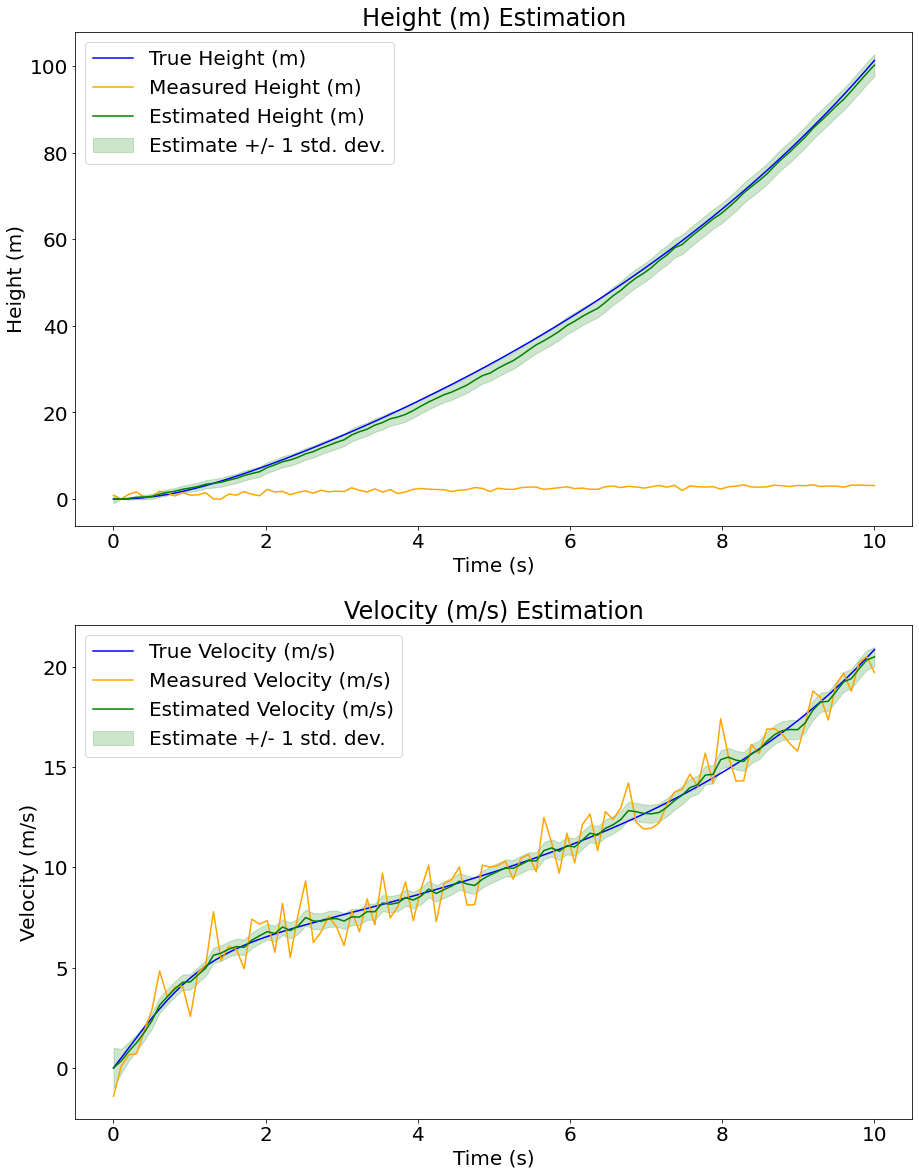

RMS Error Height (m):
  Sensor:    45.900
  Estimator: 1.095
RMS Error Velocity (m/s):
  Sensor:    0.943
  Estimator: 0.209


In [8]:
### Simulation #1
#
# Use an EKF.

# Initial state and covariance estimates
x = np.array([[0.0],
              [0.0]])
P = np.array([[1., 0.],
              [0., 1.]])

# Process noise covariance
Q = np.array([[0.1, 0.],
              [0., 0.1]])

# Measurement noise covariance
R = np.array([[height_variance, 0],
              [0, velocity_variance]])

ekf = ExtendedKalmanFilter()
ekf.simulate(
    ground_truth=np.vstack((true_height, true_velocity)).T,
    measurements=np.vstack((height_measurements, velocity_measurements)).T,
    state_variable_names=["Height (m)", "Velocity (m/s)"],
    control_inputs=commanded_acceleration,
    t=t, Q=Q, R=R, x_init=x, P_init=P,
    process_model=process_model, process_model_jacobian=process_model_jacobian,
    measurement_model=measurement_model, measurement_model_jacobian=measurement_model_jacobian,
    runtime=True
)

EKF runtime: 14.711 ms


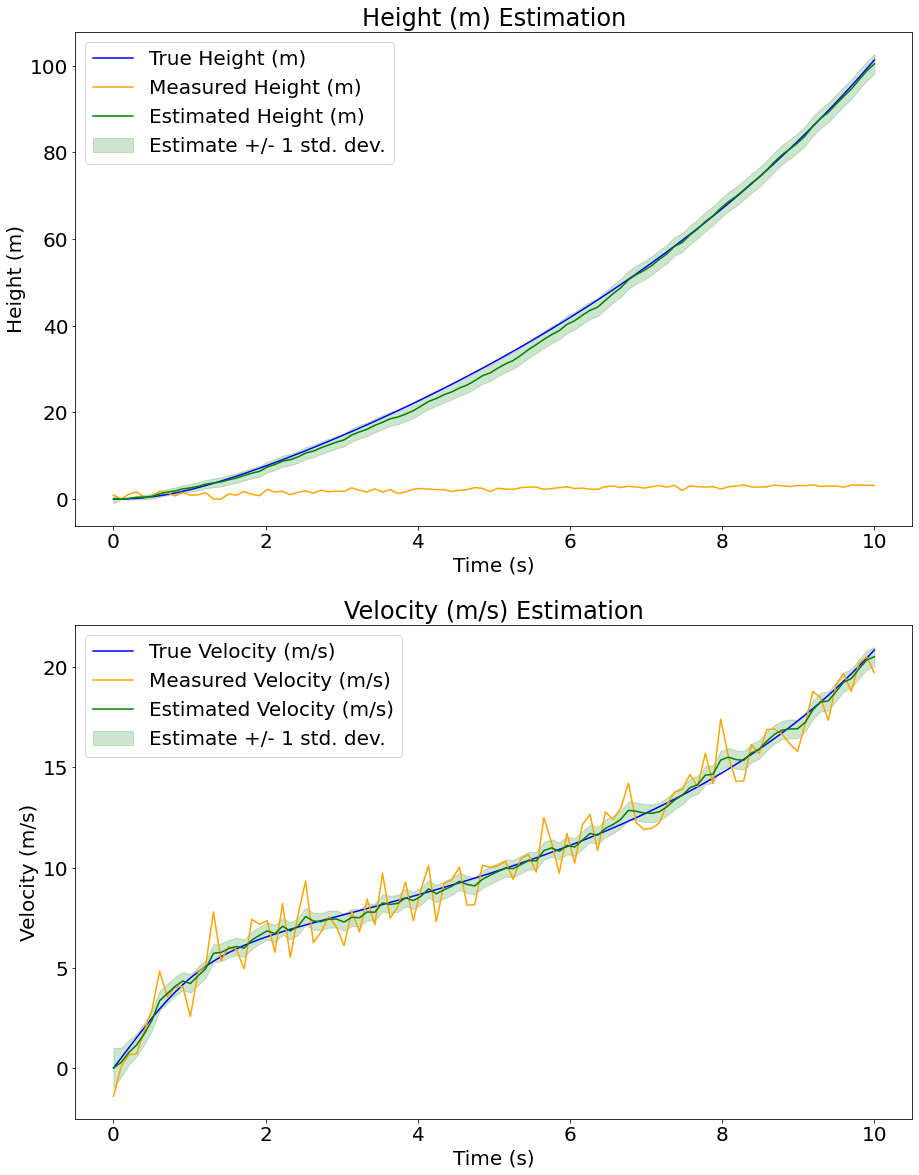

RMS Error Height (m):
  Sensor:    45.900
  Estimator: 0.986
RMS Error Velocity (m/s):
  Sensor:    0.943
  Estimator: 0.226


In [9]:
### Simulation #2
#
# Use an EKF with numerical integration.

# Initial state and covariance estimates
x = np.array([[0.0],
              [0.0]])
P = np.array([[1., 0.],
              [0., 1.]])

# Process noise covariance
Q = np.array([[0.1, 0.],
              [0., 0.1]])

# Measurement noise covariance
R = np.array([[height_variance, 0],
              [0, velocity_variance]])

ekf = NumericalExtendedKalmanFilter()
ekf.simulate(
    ground_truth=np.vstack((true_height, true_velocity)).T,
    measurements=np.vstack((height_measurements, velocity_measurements)).T,
    state_variable_names=["Height (m)", "Velocity (m/s)"],
    control_inputs=commanded_acceleration,
    t=t, Q=Q, R=R, x_init=x, P_init=P,
    process_model=process_model, measurement_model=measurement_model,
    runtime=True
)

UKF runtime: 33.277 ms


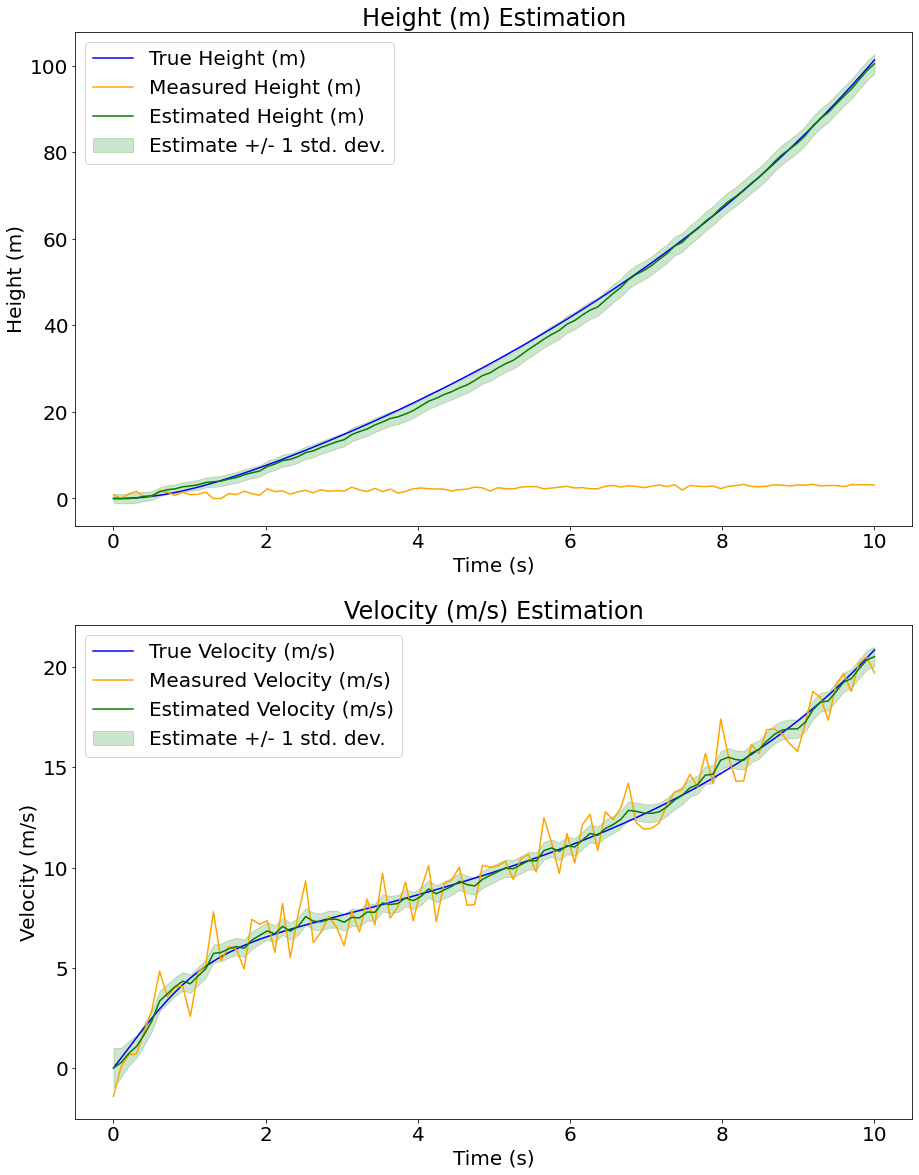

RMS Error Height (m):
  Sensor:    45.900
  Estimator: 1.019
RMS Error Velocity (m/s):
  Sensor:    0.943
  Estimator: 0.228


In [10]:
### Simulation #3
#
# Use a UKF.

# Initial state and covariance estimates
x = np.array([[0.0],
              [0.0]])
P = np.array([[1., 0.],
              [0., 1.]])

# Process noise covariance
Q = np.array([[0.1, 0.],
              [0., 0.1]])

# Measurement noise covariance
R = np.array([[height_variance, 0],
              [0, velocity_variance]])

ukf = CustomUnscentedKalmanFilter(dim_x=2, dim_z=2, alpha=0.01, beta=2, kappa=1)
ukf.simulate(
    ground_truth=np.vstack((true_height, true_velocity)).T,
    measurements=np.vstack((height_measurements, velocity_measurements)).T,
    state_variable_names=["Height (m)", "Velocity (m/s)"],
    control_inputs=commanded_acceleration,
    t=t, Q=Q, R=R, x_init=x[:,0], P_init=P,
    process_model=process_model, measurement_model=measurement_model,
    runtime=True
)